In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from data import InMemoryFloodEventDataset
from utils import file_utils

In [3]:
config_path = 'configs/config.yaml'
config = file_utils.read_yaml_file(config_path)

In [4]:
mode = 'test'

dataset_parameters = config['dataset_parameters']
if mode == 'train':
    dataset_summary_file = dataset_parameters['training']['dataset_summary_file']
    event_stats_file = dataset_parameters['training']['event_stats_file']
else: # mode == 'test'
    dataset_summary_file = dataset_parameters['testing']['dataset_summary_file']
    event_stats_file = dataset_parameters['testing']['event_stats_file']

dataset = InMemoryFloodEventDataset(
    mode=mode,
    root_dir=dataset_parameters['root_dir'],
    dataset_summary_file=dataset_summary_file,
    nodes_shp_file=dataset_parameters['nodes_shp_file'],
    edges_shp_file=dataset_parameters['edges_shp_file'],
    event_stats_file=event_stats_file,
    features_stats_file=dataset_parameters['features_stats_file'],
    previous_timesteps=dataset_parameters['previous_timesteps'],
    normalize=dataset_parameters['normalize'],
    spin_up_timesteps=dataset_parameters['spin_up_timesteps'],
    timesteps_from_peak=dataset_parameters['timesteps_from_peak'],
    inflow_boundary_edges=dataset_parameters['inflow_boundary_edges'],
    outflow_boundary_nodes=dataset_parameters['outflow_boundary_nodes'],
)

Processing timesteps: 100%|██████████| 65059/65059 [00:13<00:00, 4785.06it/s]


In [5]:
print(f'Total number of events: {len(dataset.hec_ras_run_ids)}')
print(f'Total number of timesteps: {len(dataset)}')

Total number of events: 4
Total number of timesteps: 65059


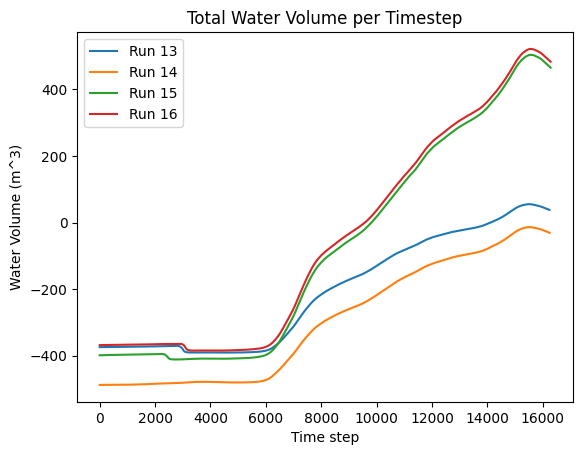

In [6]:
num_events = len(dataset.hec_ras_run_ids)
dynamic_nodes_paths = dataset.processed_paths[3:(num_events + 3)]

for run_id, path in zip(dataset.hec_ras_run_ids, dynamic_nodes_paths):
    dynamic_nodes = np.load(path)['dynamic_nodes']
    water_volume_idx = InMemoryFloodEventDataset.DYNAMIC_NODE_FEATURES.index('water_volume')
    water_volume = dynamic_nodes[:, :, water_volume_idx]
    total_water_volume = water_volume.sum(axis=1)
    plt.plot(total_water_volume, label=f'Run {run_id}')

plt.title(f'Total Water Volume per Timestep')
plt.xlabel('Time step')
plt.ylabel('Water Volume (m^3)')
plt.legend()
plt.show()

In [10]:
trimmed_dataset = dataset[:100]
for graph in tqdm(trimmed_dataset):
    non_boundary_edges_mask = ~np.isin(np.arange(graph.edge_index.shape[1]), graph.boundary_edges)
    non_boundary_edge_attr = graph.edge_attr[non_boundary_edges_mask, :]

    mid_edge_idx = non_boundary_edge_attr.shape[0] // 2
    num_dim_per_dynamic = (dataset.previous_timesteps + 1)
    num_dynamic_edge_dims = dataset.num_dynamic_edge_features * num_dim_per_dynamic
    first_half_edge_attr = non_boundary_edge_attr[:mid_edge_idx, -num_dynamic_edge_dims:]
    second_half_edge_attr = non_boundary_edge_attr[mid_edge_idx:, -num_dynamic_edge_dims:]

    for i, feat in enumerate(dataset.DYNAMIC_EDGE_FEATURES):
        feat_start_idx = i * num_dim_per_dynamic
        feat_end_idx = feat_start_idx + num_dim_per_dynamic
        first_half_feature = dataset._denormalize(feat, first_half_edge_attr[:, feat_start_idx:feat_end_idx])
        second_half_feature = dataset._denormalize(feat, second_half_edge_attr[:, feat_start_idx:feat_end_idx])

        # Use allclose due to potential floating point precision issues
        assert torch.allclose(first_half_feature, -second_half_feature, atol=1e-5),\
            "Dynamic edge attributes must be opposite in the two halves."

100%|██████████| 100/100 [00:00<00:00, 1536.09it/s]


In [ ]:
dynamic_node_feat = dataset._get_dynamic_node_features()
dynamic_node_feat.shape
# denorm_water_depth = dataset.denormalize(water_depth, water_depth_mean, water_depth_std)
# wd_diff = np.abs(np.diff(denorm_water_depth, axis=0))
# total_wd_diff_per_node = wd_diff.sum(axis=0)

# # Get top k nodes with the highest water depth difference
# k = 10
# top_k_diff_idx = np.argsort(total_wd_diff_per_node)[-k:][::-1]
# top_k_wd_diff = total_wd_diff_per_node[top_k_diff_idx]

# print('Nodes with the highest water volume difference:')
# print(list(top_k_diff_idx))
# for idx, wd in zip(top_k_diff_idx, top_k_wd_diff):
#     print(f"Node {idx}: {wd:.2f} m")
